# Bayesian A/B testing

## What is Bayesian inference?

Bayesian inference differs from more traditional statistical inference by preserving uncertainty. At first, this sounds like a bad statistical technique. Isn't statistics all about deriving certainty from randomness? To reconcile this, we need to start thinking like Bayesians.

The Bayesian world-view interprets probability as measure of believability in an event, that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability.

For this to be clearer, we consider an alternative interpretation of probability: Frequentist, known as the more classical version of statistics, assume that probability is the long-run frequency of events (hence the bestowed title). For example, the probability of plane accidents under a frequentist philosophy is interpreted as the long-term frequency of plane accidents. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: we often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability.

Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of belief, or confidence, of an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event has no confidence that the event will occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain of an event occurring. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the probability of a plane accident example, for having observed the frequency of plane accidents, an individual's belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: how confident are you candidate A will win?

## Bayesian A/B testing
A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results.

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards.

Often, the post-experiment analysis is done using something called a hypothesis test like difference of means test or difference of proportions test. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily learned this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural.

## Example

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30. In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

### Imports

In [43]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Load Data

In [3]:
df = pd.read_csv('cookie_cats.csv')

In [4]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
sum(site_A['retention_1'].astype(int) == 1) / (sum(site_A['retention_1'].astype(int) == 0))

NameError: name 'site_A' is not defined

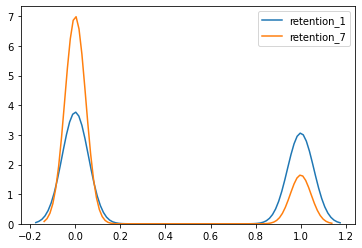

In [12]:
site_A = df[df['version'] == 'gate_30']
sns.kdeplot(site_A['retention_1']); # beta a=1, b=8 to 10
sns.kdeplot(site_A['retention_7']);

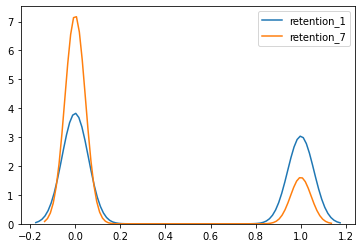

In [13]:
site_B = df[df['version'] == 'gate_40']
sns.kdeplot(site_B['retention_1']); # beta a=2, b=8 to 10
sns.kdeplot(site_B['retention_7']);

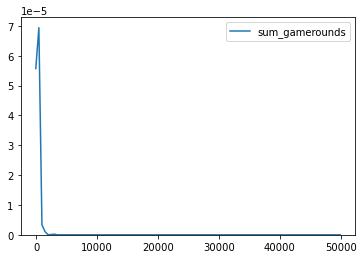

In [11]:
sns.kdeplot(df['sum_gamerounds']);

In [4]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [19]:
N_A = 44700
N_B = 45489

observations_A = df[df['version'] == 'gate_30']['retention_1'].values.astype(int)
observations_B = df[df['version'] == 'gate_40']['retention_1'].values.astype(int)

print('The number of users retained after 1 day in variant A:', observations_A.sum())
print('The number of users retained after 1 day in variant B:', observations_B.sum())

The number of users retained after 1 day in variant A: 20034
The number of users retained after 1 day in variant B: 20119


In [7]:
df.groupby('version').mean()[['retention_1','retention_7']]

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [24]:
#these two quantities are unknown to us.
true_p_A = 0.448188
true_p_B = 0.442283
# Set up the pymc3 model. Assume Beta priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Beta("p_A", 11, 14)
    p_B = pm.Beta("p_B", 11, 14)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [01:09<00:00, 1183.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [25]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

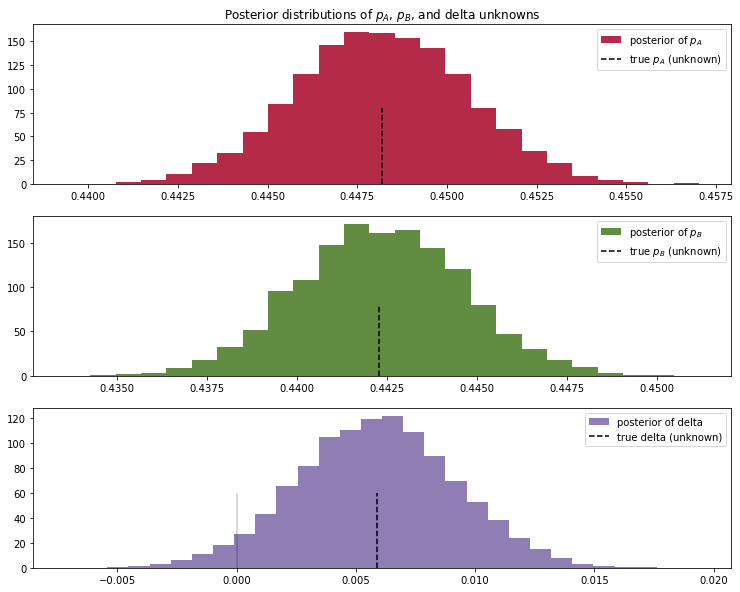

In [26]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [27]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.040
Probability site A is BETTER than site B: 0.960


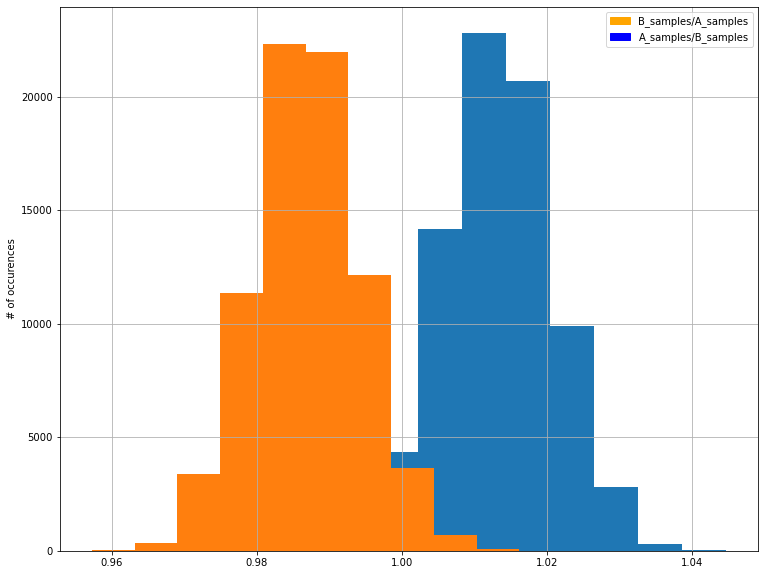

In [47]:
# calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples/p_B_samples
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch,blue_patch])
plt.ylabel('# of occurences');
# calculate relative performance of B
B_relative = p_B_samples/p_A_samples
pd.Series(B_relative).hist();

This plot tells us that a 1.01-1.02x improvement from variant A is most likely

### Trying different prior distributions

#### Uniform prior

In [48]:
#these two quantities are unknown to us.
true_p_A = 0.448188
true_p_B = 0.442283
# Set up the pymc3 model. Assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [01:01<00:00, 1328.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


Probability site A is WORSE than site B: 0.037
Probability site A is BETTER than site B: 0.963


In [52]:
#these two quantities are unknown to us.
true_p_A = 0.448188
true_p_B = 0.442283
# Set up the pymc3 model.
with pm.Model() as model:
    alpha = pm.HalfFlat()
    beta = pm.HalfFlat()
    p_A = pm.Potential("p_A", -tt.log(alpha*beta))
    p_B = pm.Potential("p_B", -tt.log(alpha*beta))
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets. 
    # These are the likelihoods using Bernoulli distribution
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

TypeError: __new__() missing 1 required positional argument: 'name'

### Retention rate after 7 days

In [28]:
observations_A2 = df[df['version'] == 'gate_30']['retention_7'].values.astype(int)
observations_B2 = df[df['version'] == 'gate_40']['retention_7'].values.astype(int)
print('The number of users retained after 7 days in variant A:', observations_A2.sum())
print('The number of users retained after 7 days in variant B:', observations_B2.sum())

The number of users retained after 7 days in variant A: 8502
The number of users retained after 7 days in variant B: 8279


In [53]:
#these two quantities are unknown to us.
true_p_A = 0.190201
true_p_B = 0.182000
# Set up the pymc3 model.
with pm.Model() as model2:
    p_A = pm.Beta("p_A", alpha=2.5, beta=8)
    p_B = pm.Beta("p_B", alpha=2.2, beta=8)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A2)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B2)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [00:57<00:00, 1434.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [54]:
p_A_samples2 = burned_trace["p_A"]
p_B_samples2 = burned_trace["p_B"]
delta_samples2 = burned_trace["delta"]

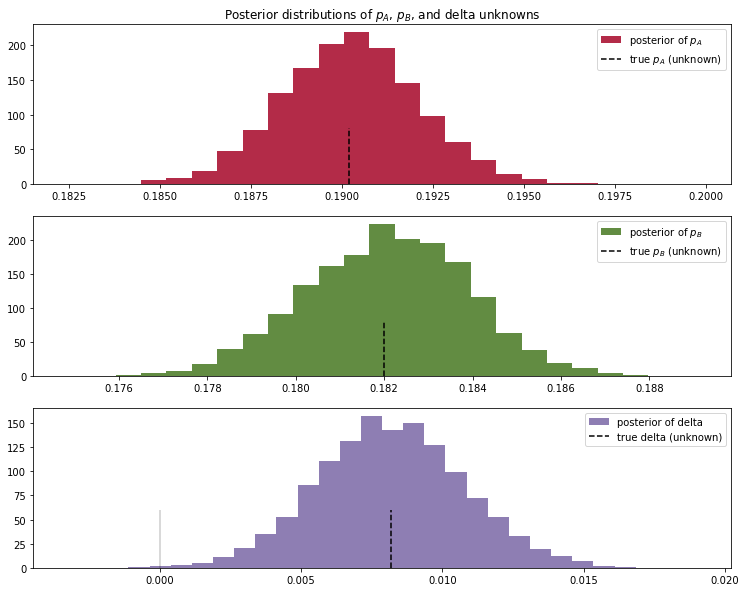

In [55]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples2, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples2, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples2, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [56]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples2 < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples2 > 0))

Probability site A is WORSE than site B: 0.001
Probability site A is BETTER than site B: 0.999


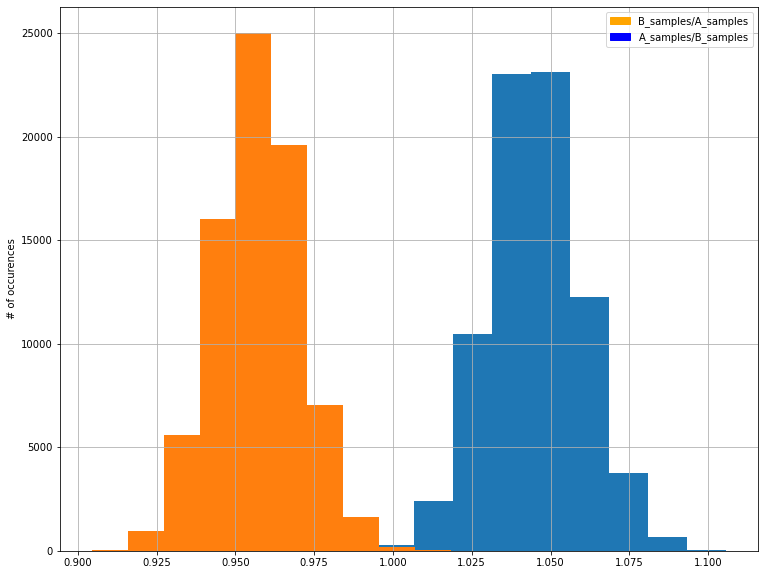

In [57]:
# calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples2/p_B_samples2
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch,blue_patch])
plt.ylabel('# of occurences');
# calculate relative performance of B
B_relative = p_B_samples2/p_A_samples2
pd.Series(B_relative).hist();

This plot tells us that a 1.03-1.06x improvement from variant A is most likely

### Trying different priors

In [59]:
#these two quantities are unknown to us.
true_p_A = 0.190201
true_p_B = 0.182000
# Set up the pymc3 model. Again assume Beta priors for p_A and p_B.
with pm.Model() as model2:
    p_A = pm.Beta("p_A", alpha=2.5, beta=8)
    p_B = pm.Beta("p_B", alpha=2.5, beta=8)

    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets. 
    # These are the likelihoods using Bernoulli distribution
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A2)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B2)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [00:59<00:00, 1388.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


Probability site A is WORSE than site B: 0.001
Probability site A is BETTER than site B: 0.999


In [60]:
#these two quantities are unknown to us.
true_p_A = 0.190201
true_p_B = 0.182000
# Set up the pymc3 model. Aassume Uniform priors for p_A and p_B.
with pm.Model() as model2:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets. 
    # These are the likelihoods using Bernoulli distribution
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A2)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B2)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [00:57<00:00, 1430.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


Probability site A is WORSE than site B: 0.001
Probability site A is BETTER than site B: 1.000


### Using fake data

In [63]:
#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 500
N_B = 1500
true_p_A = 0.20
true_p_B = 0.40
#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
#these two quantities are unknown to us.

# Set up the pymc3 model. Aassume Uniform priors for p_A and p_B.
with pm.Model() as model2:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)

    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets. 
    # These are the likelihoods using Bernoulli distribution
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    burned_trace=trace[1000:]

p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 82000/82000 [00:37<00:00, 2178.93draws/s]
The number of effective samples is smaller than 10% for some parameters.


Probability site A is WORSE than site B: 1.000
Probability site A is BETTER than site B: 0.000


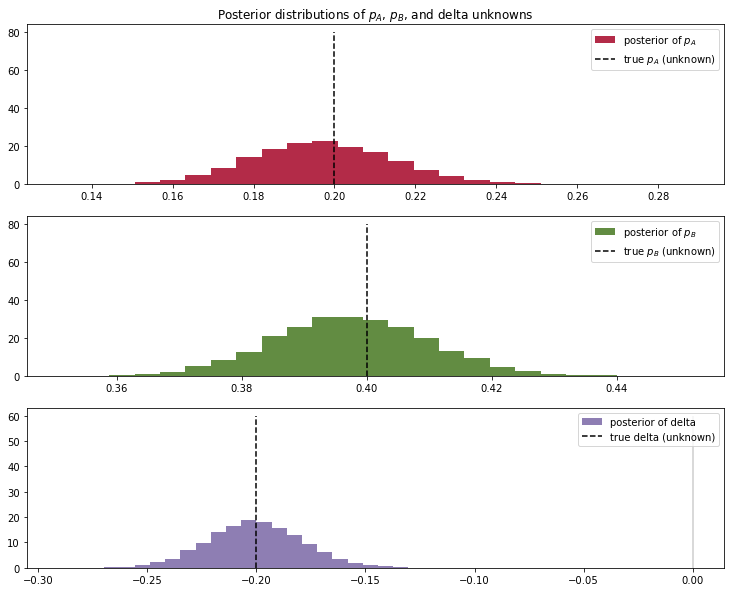

In [64]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

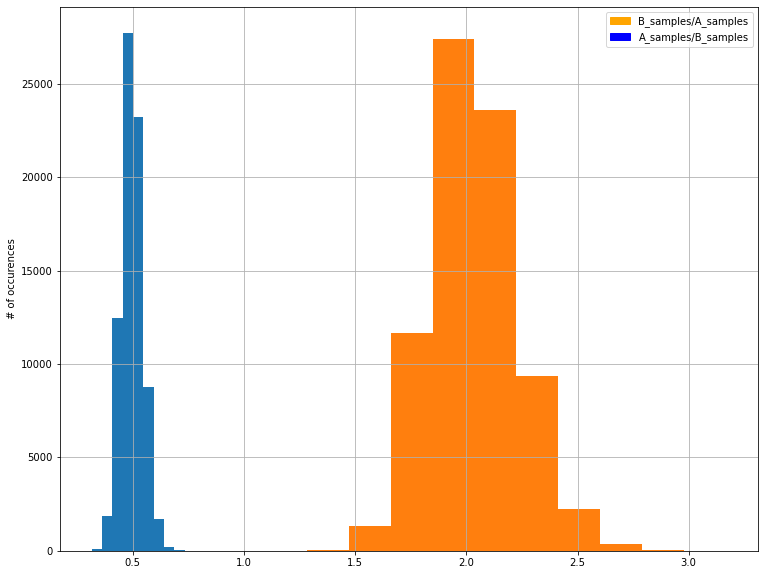

In [66]:
# calculate relative performance of A
orange_patch = mpatches.Patch(color='orange', label='B_samples/A_samples')
blue_patch = mpatches.Patch(color='blue', label='A_samples/B_samples')
A_relative = p_A_samples/p_B_samples
pd.Series(A_relative).hist()
plt.legend(handles=[orange_patch,blue_patch])
plt.ylabel('# of occurences');
# calculate relative performance of B
B_relative = p_B_samples/p_A_samples
pd.Series(B_relative).hist();